### Acetic Acid Test

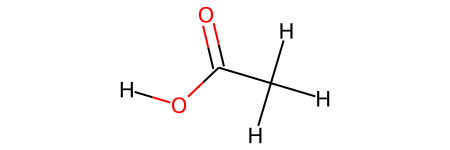

In [1]:
from rdkit import Chem

# Create test molecule of acetic acid
acetic_acid = 'CC(O)=O'

temp = Chem.MolFromSmiles(acetic_acid)
mol = Chem.AddHs(temp)
mol

In [2]:
# Define the node and edge features to be used
ATOM_FEATURES = {
    'atomic_num': [1, 6, 8]
}
ATOM_FDIM = sum(len(choices) for choices in ATOM_FEATURES)

BOND_FDIM = 4

In [3]:
from typing import List, Union

# Functions to get node and edge features
def get_OneHotEncoding(value: int, choices: List[int]) -> List[int]:
    encoding = [0] * (len(choices))
    index = choices.index(value)
    encoding[index] = 1

    return encoding

def get_atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None) -> List[Union[bool, int, float]]:
    if atom is None:
        features = [0] * ATOM_FDIM
    else:
        features = get_OneHotEncoding(atom.GetAtomicNum(), ATOM_FEATURES['atomic_num'])
    
    return features

def get_bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    if bond is None:
        fbond = [1] + [0] * (BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [0,
                 int(bt == Chem.rdchem.BondType.SINGLE),
                 int(bt == Chem.rdchem.BondType.DOUBLE),
                 int(bt == Chem.rdchem.BondType.AROMATIC),
                 int(bond.GetIsConjugated() if bt is not None else 0),
                 int(bond.IsInRing() if bt is not None else 0)
                 ]

    return fbond    

In [4]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

# Create graph for acetic acid
G = nx.Graph()

# Create feature vectors
for atom in mol.GetAtoms():
    G.add_node(atom.GetIdx(), x=get_atom_features(atom))

for bond in mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(),
    edge_attrs=get_bond_features(bond))

pyg_graph = from_networkx(G)


/home/a3782/anaconda3/envs/go_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


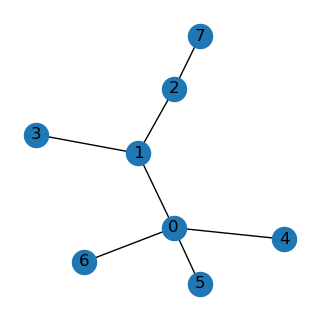

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the graph
plt.figure(figsize=(3,3))

nx.draw(G, with_labels=True)

plt.show()

In [6]:
# Print graph details
print(pyg_graph)
print('---')
print(pyg_graph.x)
print('---')
print(pyg_graph.edge_index)
print('---')
print(pyg_graph.edge_attrs)

Data(x=[8, 3], edge_index=[2, 14], edge_attrs=[14, 6])
---
tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])
---
tensor([[0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 5, 6, 7],
        [1, 4, 5, 6, 0, 2, 3, 1, 7, 1, 0, 0, 0, 2]])
---
<bound method BaseData.edge_attrs of Data(x=[8, 3], edge_index=[2, 14], edge_attrs=[14, 6])>


In [7]:
from torch_geometric.nn import GCNConv

# Set up GCN layer
conv1 = GCNConv(3, 3)
# Ready data for GCN
x = pyg_graph.x.float()
edge_index = pyg_graph.edge_index
edge_attrs = pyg_graph.edge_attrs

In [8]:
# Pass data through GCN layer
out = conv1(x, edge_index)
print(out)


tensor([[-0.2757,  0.5450, -0.7764],
        [-0.4016, -0.9790, -0.8574],
        [-0.3111, -0.1622, -0.7048],
        [-0.3109, -0.7500, -0.6594],
        [-0.1559,  0.2129, -0.4587],
        [-0.1559,  0.2129, -0.4587],
        [-0.1559,  0.2129, -0.4587],
        [-0.3407,  0.0839, -0.6749]], grad_fn=<AddBackward0>)


In [9]:
import torch.nn.functional as F

# Pass through ReLU
out = F.relu(out)
print(out)

tensor([[0.0000, 0.5450, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.2129, 0.0000],
        [0.0000, 0.2129, 0.0000],
        [0.0000, 0.2129, 0.0000],
        [0.0000, 0.0839, 0.0000]], grad_fn=<ReluBackward0>)


In [10]:
import torch.nn as nn

BN = nn.BatchNorm1d(3)

In [11]:
#  Pass through batch normalisation
out = BN(out)
print(out)

tensor([[ 0.0000,  2.2349,  0.0000],
        [ 0.0000, -0.9162,  0.0000],
        [ 0.0000, -0.9162,  0.0000],
        [ 0.0000, -0.9162,  0.0000],
        [ 0.0000,  0.3151,  0.0000],
        [ 0.0000,  0.3151,  0.0000],
        [ 0.0000,  0.3151,  0.0000],
        [ 0.0000, -0.4314,  0.0000]], grad_fn=<NativeBatchNormBackward0>)


### GO Test

In [1]:
from Dataset import XASDataset
from icecream import ic

# Path raw directory containing the data
path = "./"
# Load and create the dataset
dataset = XASDataset(path)

/home/a3782/anaconda3/envs/go_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('------------')
# Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(7946)
------------
Number of graphs: 7946
Number of features: 10
Number of classes: 1536450
------------
Data(x=[32, 10], edge_index=[2, 78], y=[200], weight=[78, 6], vector=[10], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[c:11]([CH:25]=[O:29])[cH:13][c:14]6[c:12]4[c:17]4[c:19]([c:18]([CH:26]=[O:31])[c:15]6[OH:16])=[CH:20][CH:22]6[C:23]([c:21]14)([CH:24]=[CH:1][C:2]2=[CH:3][CH2:5][C:6]3([CH:27]=[O:30])[CH:7]=[CH:9]5)[O:28]6', atom_num=[1], neighbors=[3])
------------
Number of nodes: 32
Number of edges: 78
Average node degree: 2.44
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [64]:
from torch_geometric.loader import DataLoader

train_dataset = dataset[0:5]
val_dataset = dataset[252:280]
test_dataset = dataset[280:]

test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

print(f'Length of training data loader: {len(train_loader.dataset)}')
print(f'Length of validation data loader: {len(val_loader.dataset)}')
print(f'Length of testing data loader: {len(test_loader.dataset)}')

Length of training data loader: 5
Length of validation data loader: 28
Length of testing data loader: 7666


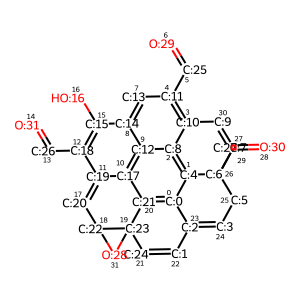

In [65]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.6

data = train_loader.dataset[0]

mol = Chem.MolFromSmiles(data.smiles)
mol

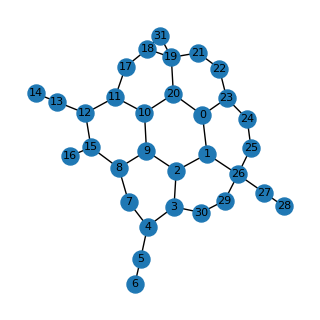

Atom: tensor([18])
Neighbours: [17, 19, 31]


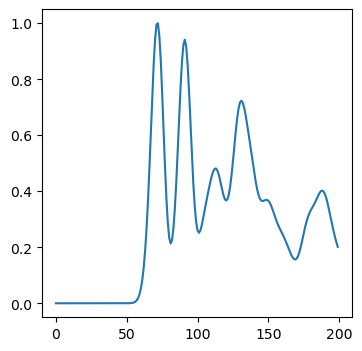

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

# Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

print(f'Atom: {data.atom_num}')
print(f'Neighbours: {data.neighbors}')

# Show molecule spectrum
plt.figure(figsize=(4,4))

plt.plot(data.y)

plt.show()

In [67]:
data.x[18]

tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0])

In [68]:
for i in train_loader:
    print(i)

DataBatch(x=[150, 10], edge_index=[2, 378], y=[1000], weight=[378, 6], vector=[50], smiles=[5], atom_num=[5], neighbors=[5], batch=[150], ptr=[6])


In [69]:
print(train_loader.dataset[0].atom_num)
print(train_loader.dataset[1].atom_num)


tensor([18])
tensor([21])


In [70]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch_geometric.nn import global_mean_pool
import imageio
import matplotlib.animation as animation


In [78]:
class GNN(torch.nn.Module):

    def __init__(self):

        super(GNN, self).__init__()

        self.conv1 = GCNConv(10, 100)
        self.conv2 = GCNConv(100, 250)
        self.conv3 = GCNConv(250, 400)

        self.lin = torch.nn.Linear(400, 200)

        self.pool = global_mean_pool

    def forward(self, batched_data):
        x = batched_data.x.float()
        edge_index = batched_data.edge_index
        edge_attrs = batched_data.weight.float()
        
        h = self.conv1(x, edge_index)
        h = F.relu(h)

        h = self.conv2(h, edge_index)
        h = F. relu(h)

        h = self.conv3(h, edge_index)
        
        h_graph = self.pool(h, batched_data.batch)

        h_out = self.lin(h_graph)

        return h_out



In [79]:
model = GNN()
print(model)

GNN(
  (conv1): GCNConv(10, 100)
  (conv2): GCNConv(100, 250)
  (conv3): GCNConv(250, 400)
  (lin): Linear(in_features=400, out_features=200, bias=True)
)


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=0.000001)

In [81]:
def train(loader):

    loss_all = 0

    model.train()

    for batch in loader:
        batch = batch.to(device)

        optimizer.zero_grad()

        pred = model(batch)

        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        loss = nn.MSELoss()(pred.double(), batch.y.double())

        loss.backward()

        loss_all += loss.item() * batch.num_graphs

        optimizer.step()

        out = pred[0].detach().numpy()
        true = batch.y[0].detach().numpy()


    return loss, out, true

In [82]:
num_epochs = 100

ims = []

for epoch in range(num_epochs):

    loss, out, true = train(train_loader)

    plt.plot(out)
    plt.plot(true)
    #plt.plot(train_loader.dataset[0].y)
    #plt.plot(train_loader.dataset[1].y)
    plt.ylim(-0.2, 1.2)
    plt.xlim(0, 200)
    plt.title(f'epoch: {epoch}')
    plt.savefig(f'./images/graph_{epoch}.png')
    plt.close()

In [83]:
frames = []

for t in range(num_epochs):
    image = imageio.v2.imread(f'./images/graph_{t}.png')
    frames.append(image)

In [84]:
imageio.mimsave('./example.gif', frames, fps=4)